In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                    df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())

new_df.drop(columns=['Total Bsmt SF', 'Fireplaces', 'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                     'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Exposure', 
                     'Lot Config', 'Condition 2', 'Garage Type', 'Garage Finish', 'Garage Qual',
                     'Pool QC', 'Fence', 'Lot Shape', 'Land Slope', 'Fireplace Qu', 'Yr Sold',
                     'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF', 'Garage Yr Blt', 
                     'Garage Cond', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 
                     '3Ssn Porch', 'Screen Porch', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                     'Bsmt Unf SF', 'Low Qual Fin SF', 'PID'], inplace=True)

new_df = new_df[new_df['Electrical'].notnull()]

print(new_df.shape)

(2929, 56)


In [27]:
X = new_df.drop(columns=['SalePrice'])
y = new_df['SalePrice']

ordinal_features = ['Utilities', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 
                    'Bsmt Qual', 'Bsmt Cond', 'Heating QC','Kitchen Qual', 'Functional', 'Paved Drive']

nominal_features = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Neighborhood', 
                    'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 
                    'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 
                    'Central Air', 'Misc Feature', 'Sale Type', 'Sale Condition', 'Electrical']

X_cat = X.copy()
bool_cols = X_cat.select_dtypes(include=['bool']).columns
X_cat[bool_cols] = X_cat[bool_cols].astype('object')

label_encoders = {}
for col in ordinal_features:
    if col in X_cat.columns:
        le = LabelEncoder()
        X_cat[col] = le.fit_transform(X_cat[col].astype(str))
        label_encoders[col] = le

nominal_present = [c for c in nominal_features if c in X_cat.columns]
if len(nominal_present) > 0:
    X_cat[nominal_present] = X_cat[nominal_present].astype(str)
    X_nominal_dummies = pd.get_dummies(X_cat[nominal_present], prefix=nominal_present)
    X_cat = X_cat.drop(columns=nominal_present)
    X_processed = pd.concat([X_cat, X_nominal_dummies], axis=1)
else:
    X_processed = X_cat.copy()

if len(bool_cols) > 0:
    X_processed[bool_cols] = X_processed[bool_cols].astype(int)

X_base = X_processed.copy()

X_base['Lot Frontage'] = X_base['Lot Frontage'].fillna(0)
X_base['Mas Vnr Area'] = X_base['Mas Vnr Area'].fillna(0)
X_base['Garage Area'] = X_base['Garage Area'].fillna(0)
X_base['Garage Cars'] = X_base['Garage Cars'].fillna(0)

print(f"\nNumber of features after encoding: {X_base.shape[1]}")
print(f"Samples: {X_base.shape[0]}")


Number of features after encoding: 209
Samples: 2929


In [28]:
def apply_log_transform(X_df):
    X_log = X_df.copy()
    
    log_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'Gr Liv Area', 
                    'Garage Area', 'TotalSF', 'TotalPorchSF']
    
    for col in log_features:
        if col in X_log.columns:
            X_log[col] = np.log1p(X_log[col])
    
    return X_log, log_features

def run_clustering_pipeline(X_data, scaler, scaler_name, use_log, pca_variance=0.95, 
                            k_range=(5, 15), random_state=42):
    
    X_scaled = scaler.fit_transform(X_data)
    X_scaled = pd.DataFrame(X_scaled, columns=X_data.columns)
    
    pca = PCA(n_components=pca_variance, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA components: {pca.n_components_}")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    
    k_min, k_max = k_range
    k_values = list(range(k_min, k_max + 1))
    inertias = []
    silhouette_scores = []
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X_pca, labels)
        silhouette_scores.append(sil_score)
        print(f"k={k:2d}: Silhouette={sil_score:.4f}")
    
    best_k = k_values[np.argmax(silhouette_scores)]
    best_sil_score = max(silhouette_scores)
    
    print(f"\nBest k: {best_k} (Silhouette Score: {best_sil_score:.4f})")
    
    kmeans_final = KMeans(n_clusters=best_k, random_state=random_state, n_init=10)
    final_labels = kmeans_final.fit_predict(X_pca)
    
    unique, counts = np.unique(final_labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    
    print("\nCluster sizes:")
    for cluster_id in range(best_k):
        count = cluster_sizes.get(cluster_id, 0)
        pct = count / len(final_labels) * 100
        print(f"  Cluster {cluster_id}: {count:4d} samples ({pct:5.1f}%)")
    
    return {
        'scaler_name': scaler_name,
        'use_log': use_log,
        'X_scaled': X_scaled,
        'pca': pca,
        'X_pca': X_pca,
        'best_k': best_k,
        'kmeans': kmeans_final,
        'labels': final_labels,
        'k_values': k_values,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'best_silhouette': best_sil_score,
        'cluster_sizes': cluster_sizes
    }

X_no_log = X_base.copy()
X_with_log, log_features_used = apply_log_transform(X_base)

all_results = {}
       


In [29]:
result = run_clustering_pipeline(
            X_data=X_no_log,
            scaler=MinMaxScaler(),
            scaler_name='MinMaxScaler',
            use_log=False,
            pca_variance=0.95,
            k_range=(5, 15),
            random_state=42
        )
        
key = f"MinMax_nolog"
all_results[key] = result

PCA components: 76
Variance explained: 0.9517
k= 5: Silhouette=0.1028
k= 6: Silhouette=0.1053
k= 7: Silhouette=0.1100
k= 8: Silhouette=0.0979
k= 9: Silhouette=0.0934
k=10: Silhouette=0.0955
k=11: Silhouette=0.1025
k=12: Silhouette=0.1066
k=13: Silhouette=0.1030
k=14: Silhouette=0.0996
k=15: Silhouette=0.1120

Best k: 15 (Silhouette Score: 0.1120)

Cluster sizes:
  Cluster 0:  208 samples (  7.1%)
  Cluster 1:  254 samples (  8.7%)
  Cluster 2:  148 samples (  5.1%)
  Cluster 3:  265 samples (  9.0%)
  Cluster 4:   88 samples (  3.0%)
  Cluster 5:  447 samples ( 15.3%)
  Cluster 6:  171 samples (  5.8%)
  Cluster 7:  237 samples (  8.1%)
  Cluster 8:  147 samples (  5.0%)
  Cluster 9:  194 samples (  6.6%)
  Cluster 10:  341 samples ( 11.6%)
  Cluster 11:   61 samples (  2.1%)
  Cluster 12:  150 samples (  5.1%)
  Cluster 13:  142 samples (  4.8%)
  Cluster 14:   76 samples (  2.6%)


In [30]:
result = run_clustering_pipeline(
            X_data=X_with_log,
            scaler=MinMaxScaler(),
            scaler_name='MinMaxScaler',
            use_log=True,
            pca_variance=0.95,
            k_range=(5, 15),
            random_state=42
        )
        
key = f"MinMax_log"
all_results[key] = result

PCA components: 75
Variance explained: 0.9501
k= 5: Silhouette=0.0932
k= 6: Silhouette=0.0991
k= 7: Silhouette=0.1039
k= 8: Silhouette=0.0905
k= 9: Silhouette=0.0978
k=10: Silhouette=0.0933
k=11: Silhouette=0.0808
k=12: Silhouette=0.0962
k=13: Silhouette=0.1062
k=14: Silhouette=0.0895
k=15: Silhouette=0.1056

Best k: 13 (Silhouette Score: 0.1062)

Cluster sizes:
  Cluster 0:  102 samples (  3.5%)
  Cluster 1:  274 samples (  9.4%)
  Cluster 2:  223 samples (  7.6%)
  Cluster 3:  153 samples (  5.2%)
  Cluster 4:  426 samples ( 14.5%)
  Cluster 5:  300 samples ( 10.2%)
  Cluster 6:  105 samples (  3.6%)
  Cluster 7:  248 samples (  8.5%)
  Cluster 8:  222 samples (  7.6%)
  Cluster 9:  137 samples (  4.7%)
  Cluster 10:  137 samples (  4.7%)
  Cluster 11:  189 samples (  6.5%)
  Cluster 12:  413 samples ( 14.1%)


In [31]:
result = run_clustering_pipeline(
            X_data=X_no_log,
            scaler=StandardScaler(),
            scaler_name='StandardScaler',
            use_log=False,
            pca_variance=0.95,
            k_range=(5, 30),
            random_state=42
        )
        
key = f"Standard_nolog"
all_results[key] = result

PCA components: 136
Variance explained: 0.9512
k= 5: Silhouette=0.0093
k= 6: Silhouette=0.0563
k= 7: Silhouette=0.0415
k= 8: Silhouette=0.0262
k= 9: Silhouette=0.0345
k=10: Silhouette=0.0421
k=11: Silhouette=0.0404
k=12: Silhouette=0.0467
k=13: Silhouette=0.0232
k=14: Silhouette=0.0193
k=15: Silhouette=0.0484
k=16: Silhouette=0.0344
k=17: Silhouette=0.0579
k=18: Silhouette=0.0307
k=19: Silhouette=0.0618
k=20: Silhouette=0.0544
k=21: Silhouette=0.0547
k=22: Silhouette=0.0286
k=23: Silhouette=0.0461
k=24: Silhouette=0.0464
k=25: Silhouette=0.0574
k=26: Silhouette=0.0773
k=27: Silhouette=0.0528
k=28: Silhouette=0.0687
k=29: Silhouette=0.0565
k=30: Silhouette=0.0565

Best k: 26 (Silhouette Score: 0.0773)

Cluster sizes:
  Cluster 0:  391 samples ( 13.3%)
  Cluster 1:   59 samples (  2.0%)
  Cluster 2:  128 samples (  4.4%)
  Cluster 3:  516 samples ( 17.6%)
  Cluster 4:   17 samples (  0.6%)
  Cluster 5:   70 samples (  2.4%)
  Cluster 6:   73 samples (  2.5%)
  Cluster 7:  341 samples ( 1

In [32]:
result = run_clustering_pipeline(
            X_data=X_with_log,
            scaler=StandardScaler(),
            scaler_name='StandardScaler',
            use_log=True,
            pca_variance=0.95,
            k_range=(5, 30),
            random_state=42
        )
        
key = f"Standard_log"
all_results[key] = result

PCA components: 135
Variance explained: 0.9519
k= 5: Silhouette=0.0048
k= 6: Silhouette=0.0207
k= 7: Silhouette=0.0245
k= 8: Silhouette=0.0205
k= 9: Silhouette=0.0432
k=10: Silhouette=0.0248
k=11: Silhouette=0.0287
k=12: Silhouette=0.0190
k=13: Silhouette=0.0214
k=14: Silhouette=0.0357
k=15: Silhouette=0.0448
k=16: Silhouette=0.0437
k=17: Silhouette=0.0504
k=18: Silhouette=0.0167
k=19: Silhouette=0.0363
k=20: Silhouette=0.0384
k=21: Silhouette=0.0289
k=22: Silhouette=0.0510
k=23: Silhouette=0.0442
k=24: Silhouette=0.0553
k=25: Silhouette=0.0644
k=26: Silhouette=0.0435
k=27: Silhouette=0.0546
k=28: Silhouette=0.0428
k=29: Silhouette=0.0595
k=30: Silhouette=0.0697

Best k: 30 (Silhouette Score: 0.0697)

Cluster sizes:
  Cluster 0:   44 samples (  1.5%)
  Cluster 1:  122 samples (  4.2%)
  Cluster 2:  435 samples ( 14.9%)
  Cluster 3:   20 samples (  0.7%)
  Cluster 4:  306 samples ( 10.4%)
  Cluster 5:   72 samples (  2.5%)
  Cluster 6:  121 samples (  4.1%)
  Cluster 7:   81 samples (  

In [42]:
comparison_data = []
for key, result in all_results.items():
    comparison_data.append({
        'Pipeline': key,
        'Scaler': result['scaler_name'],
        'PCA Components': result['pca'].n_components_,
        'Optimal K': result['best_k'],
        'Silhouette Score': result['best_silhouette'],
        'Largest Cluster Size': max(result['cluster_sizes'].values()),
        'Smallest Cluster Size': min(result['cluster_sizes'].values())
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


      Pipeline         Scaler  PCA Components  Optimal K  Silhouette Score  Largest Cluster Size  Smallest Cluster Size
  MinMax_nolog   MinMaxScaler              76         15          0.111953                   447                     61
    MinMax_log   MinMaxScaler              75         13          0.106180                   426                    102
Standard_nolog StandardScaler             136         26          0.077258                   516                      1
  Standard_log StandardScaler             135         30          0.069708                   435                      1


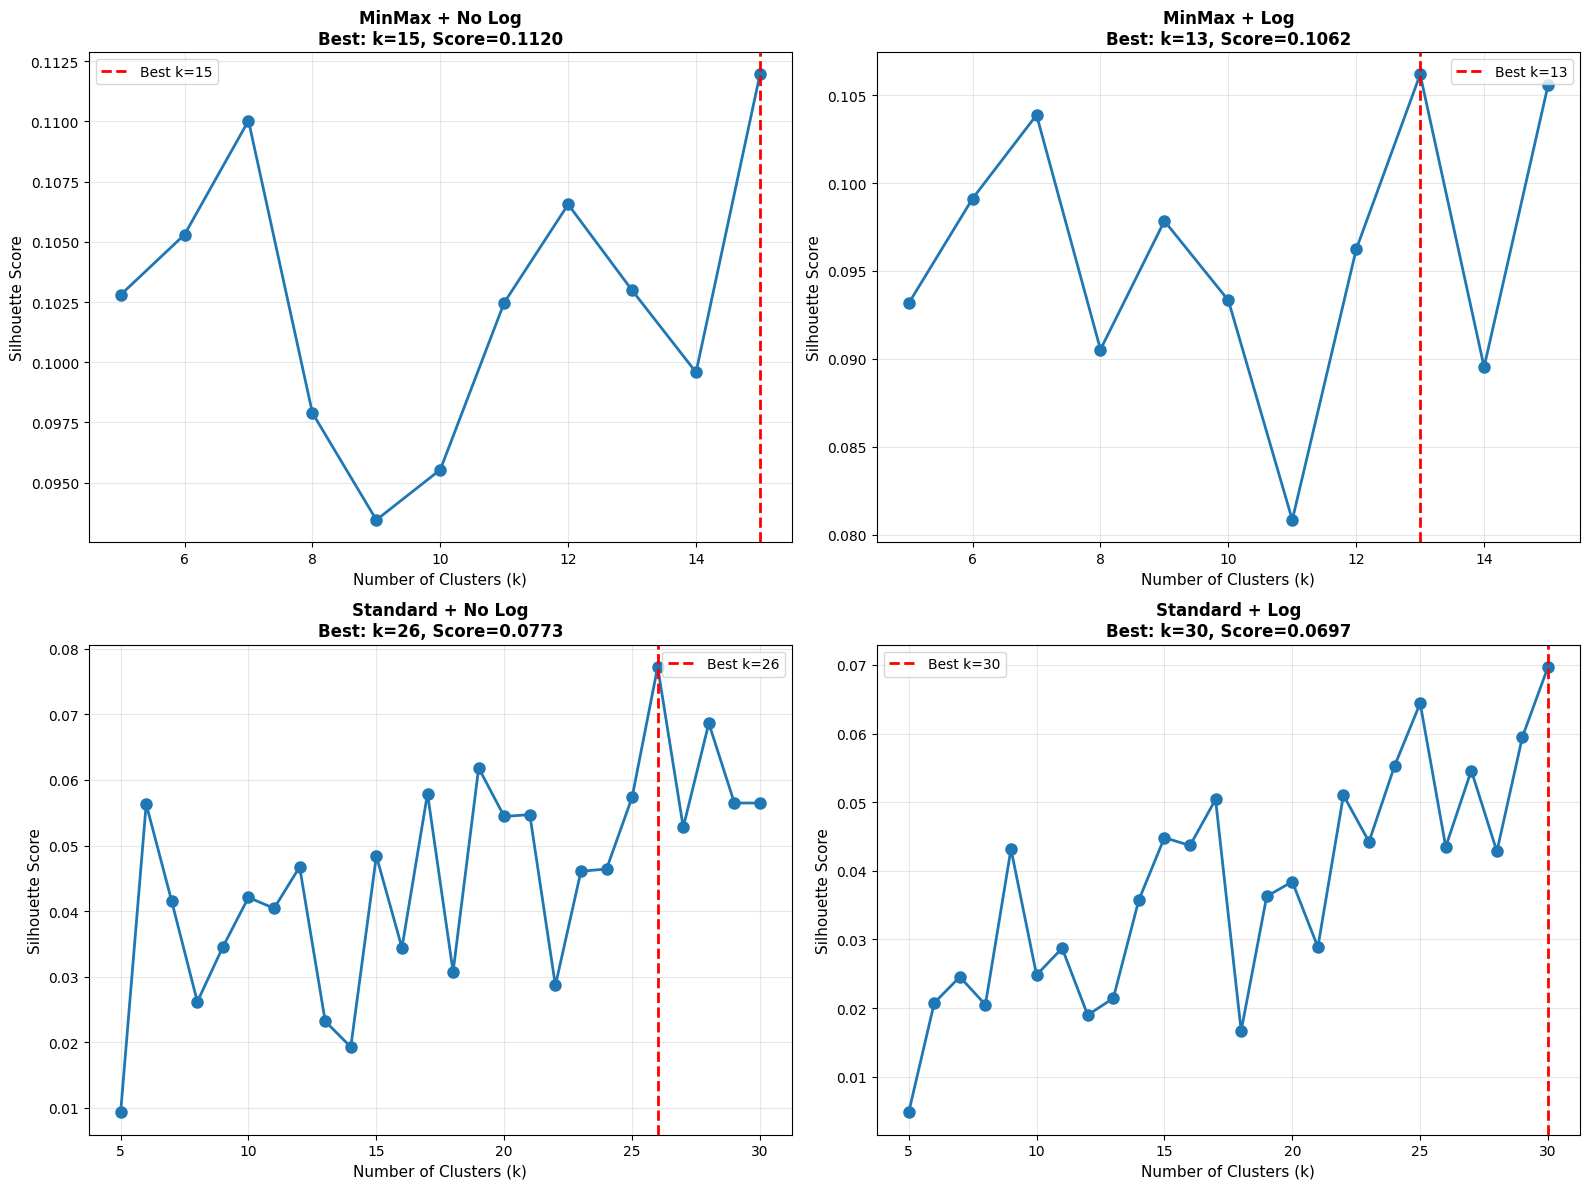

In [34]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_order = ['MinMax_nolog', 'MinMax_log', 'Standard_nolog', 'Standard_log']
plot_titles = ['MinMax + No Log', 'MinMax + Log', 'Standard + No Log', 'Standard + Log']

for idx, (key, title) in enumerate(zip(plot_order, plot_titles)):
    ax = axes[idx // 2, idx % 2]
    result = all_results[key]
    
    ax.plot(result['k_values'], result['silhouette_scores'], 'o-', linewidth=2, markersize=8)
    ax.axvline(x=result['best_k'], color='red', linestyle='--', linewidth=2, 
               label=f"Best k={result['best_k']}")
    ax.set_xlabel('Number of Clusters (k)', fontsize=11)
    ax.set_ylabel('Silhouette Score', fontsize=11)
    ax.set_title(f"{title}\nBest: k={result['best_k']}, Score={result['best_silhouette']:.4f}", 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()




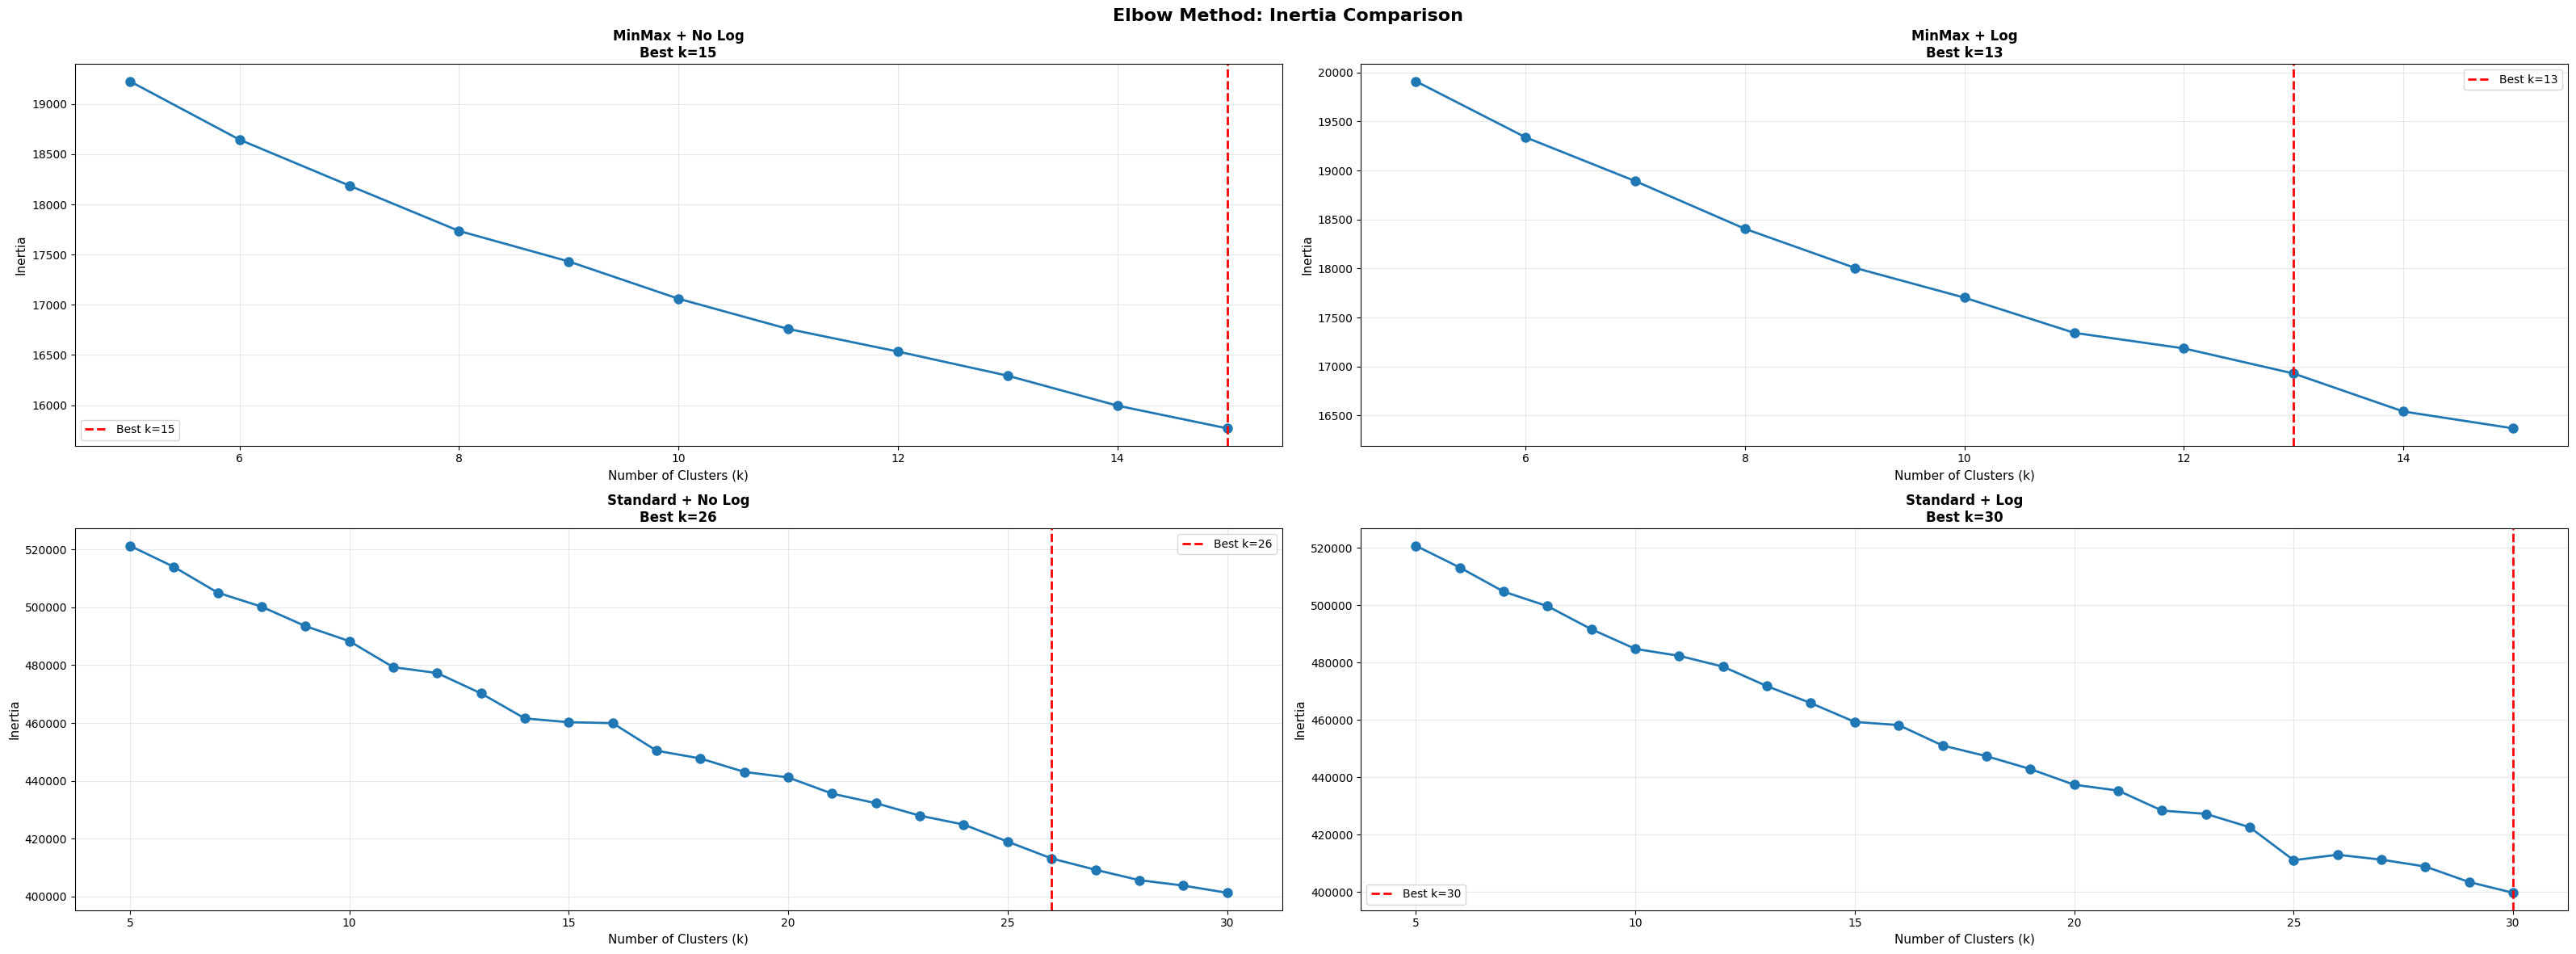

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(32, 12))
fig.suptitle('Elbow Method: Inertia Comparison', fontsize=16, fontweight='bold')

for idx, (key, title) in enumerate(zip(plot_order, plot_titles)):
    ax = axes[idx // 2, idx % 2]
    result = all_results[key]
    
    ax.plot(result['k_values'], result['inertias'], 'o-', linewidth=2, markersize=8)
    ax.axvline(x=result['best_k'], color='red', linestyle='--', linewidth=2, 
               label=f"Best k={result['best_k']}")
    ax.set_xlabel('Number of Clusters (k)', fontsize=11)
    ax.set_ylabel('Inertia', fontsize=11)
    ax.set_title(f"{title}\nBest k={result['best_k']}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()



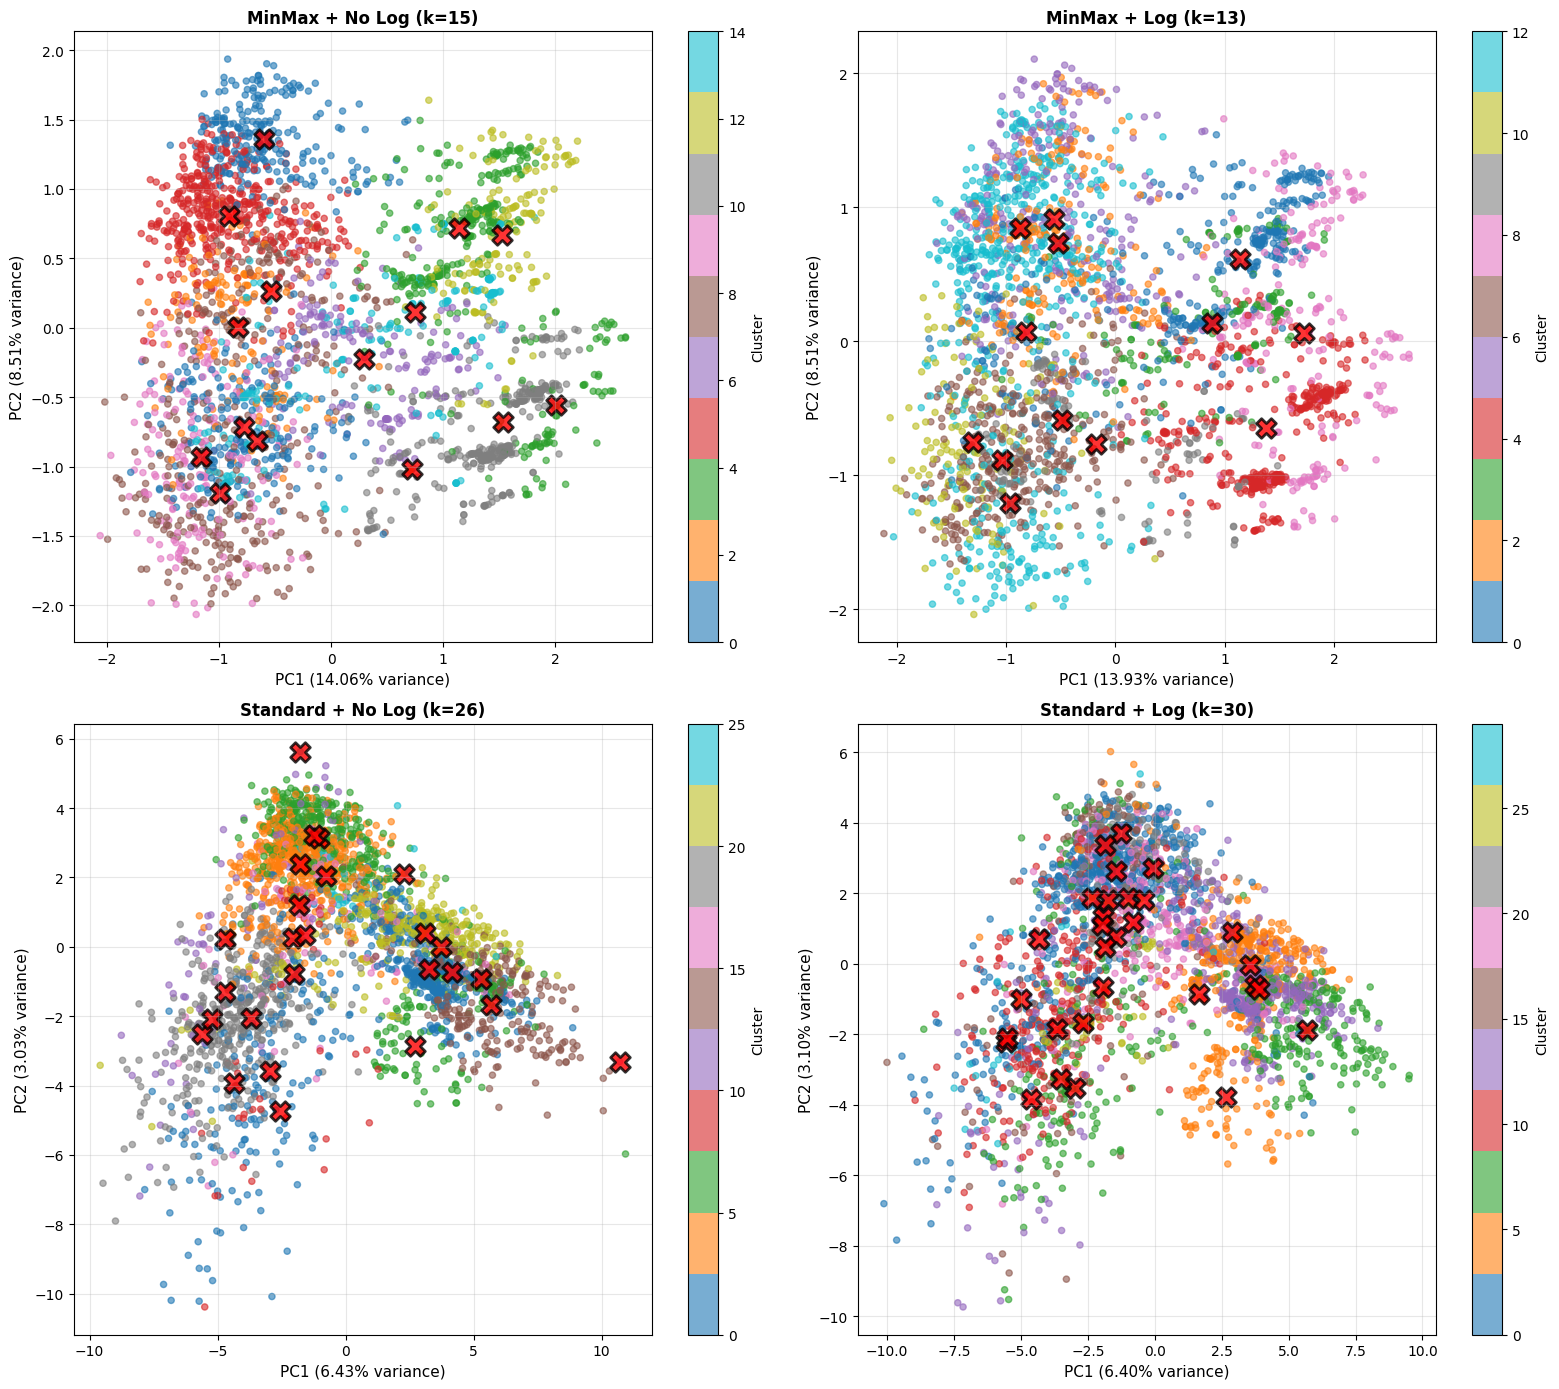

In [43]:

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, (key, title) in enumerate(zip(plot_order, plot_titles)):
    ax = axes[idx // 2, idx % 2]
    result = all_results[key]
    
    scatter = ax.scatter(result['X_pca'][:, 0], result['X_pca'][:, 1], 
                        c=result['labels'], cmap='tab10', s=20, alpha=0.6)
    
    centroids = result['kmeans'].cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], 
              c='red', s=200, alpha=0.8, marker='X', 
              edgecolors='black', linewidths=2, label='Centroids')
    
    var1 = result['pca'].explained_variance_ratio_[0]
    var2 = result['pca'].explained_variance_ratio_[1]
    
    ax.set_xlabel(f'PC1 ({var1:.2%} variance)', fontsize=11)
    ax.set_ylabel(f'PC2 ({var2:.2%} variance)', fontsize=11)
    ax.set_title(f"{title} (k={result['best_k']})", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()



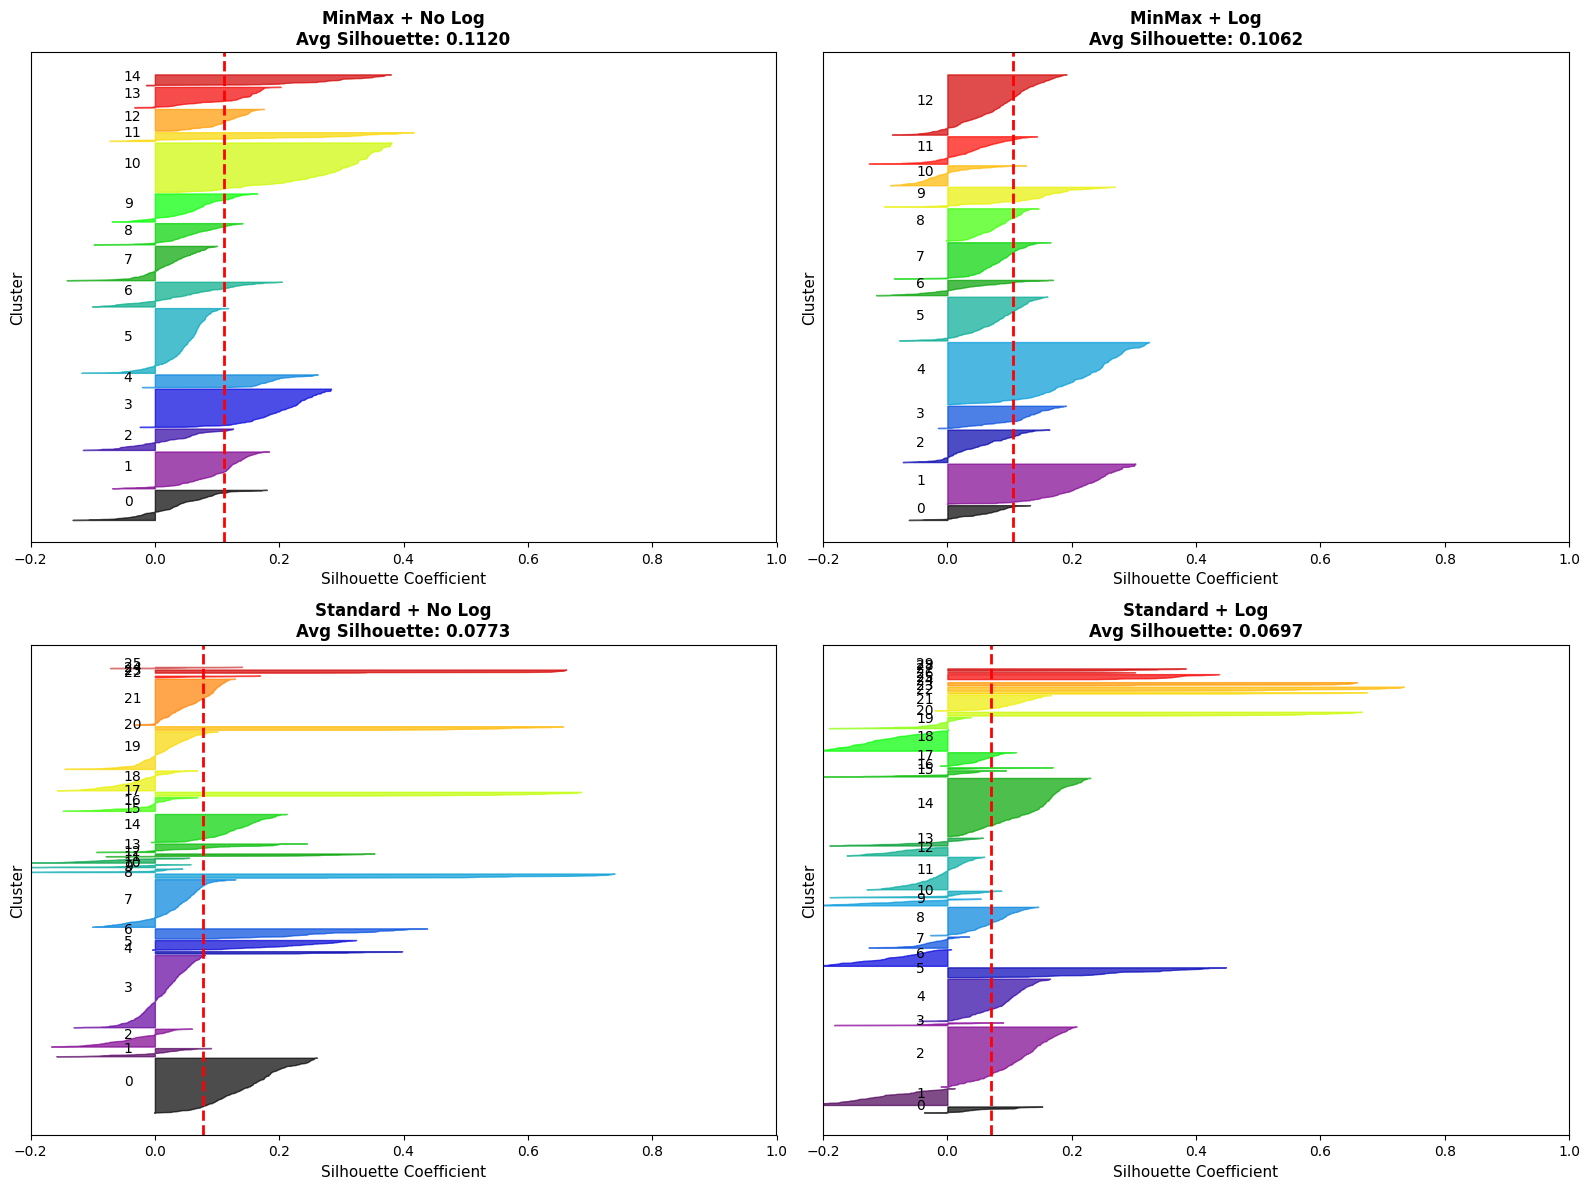

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (key, title) in enumerate(zip(plot_order, plot_titles)):
    ax = axes[idx // 2, idx % 2]
    result = all_results[key]
    
    best_k = result['best_k']
    labels = result['labels']
    X_pca = result['X_pca']
    
    sample_silhouette_values = silhouette_samples(X_pca, labels)
    
    y_lower = 10
    for i in range(best_k):
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / best_k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.set_title(f"{title}\nAvg Silhouette: {result['best_silhouette']:.4f}", 
                fontsize=12, fontweight='bold')
    ax.set_xlabel("Silhouette Coefficient", fontsize=11)
    ax.set_ylabel("Cluster", fontsize=11)
    ax.axvline(x=result['best_silhouette'], color="red", linestyle="--", linewidth=2)
    ax.set_yticks([])
    ax.set_xlim([-0.2, 1])

plt.tight_layout()
plt.show()



In [38]:


best_config_key = max(all_results.items(), key=lambda x: x[1]['best_silhouette'])[0]
best_result = all_results[best_config_key]

print(f"\nAnalyzing best configuration: {best_config_key}")
print(f"Silhouette Score: {best_result['best_silhouette']:.4f}")

analysis_df = new_df.copy()
analysis_df['Cluster'] = best_result['labels']

key_features = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'TotalSF', 'TotalBath', 
                'Garage Area', 'Garage Cars', 'hasBasement', 'hasGarage', 'hasFireplace']

print("\nCluster Statistics:")
cluster_stats = analysis_df.groupby('Cluster')[key_features].mean()
print(cluster_stats.to_string())




Analyzing best configuration: MinMax_nolog
Silhouette Score: 0.1120

Cluster Statistics:
             SalePrice  Overall Qual  Gr Liv Area      TotalSF  TotalBath  Garage Area  Garage Cars  hasBasement  hasGarage  hasFireplace
Cluster                                                                                                                                  
0        154119.009615      5.596154  1558.634615  2381.740385   1.793269   363.370192     1.365385     0.985577   0.923077      0.591346
1        162812.055118      5.736220  1351.771654  2571.484252   2.059055   466.078740     1.692913     0.980315   0.996063      0.625984
2        136883.885135      5.297297  1477.668919  2476.351351   2.456081   416.736486     1.628378     0.817568   0.804054      0.222973
3        245678.939623      7.286792  1550.264151  3097.539623   2.520755   627.264151     2.290566     1.000000   0.962264      0.543396
4        291866.068182      7.784091  2155.840909  3365.250000   3.011364   680.39

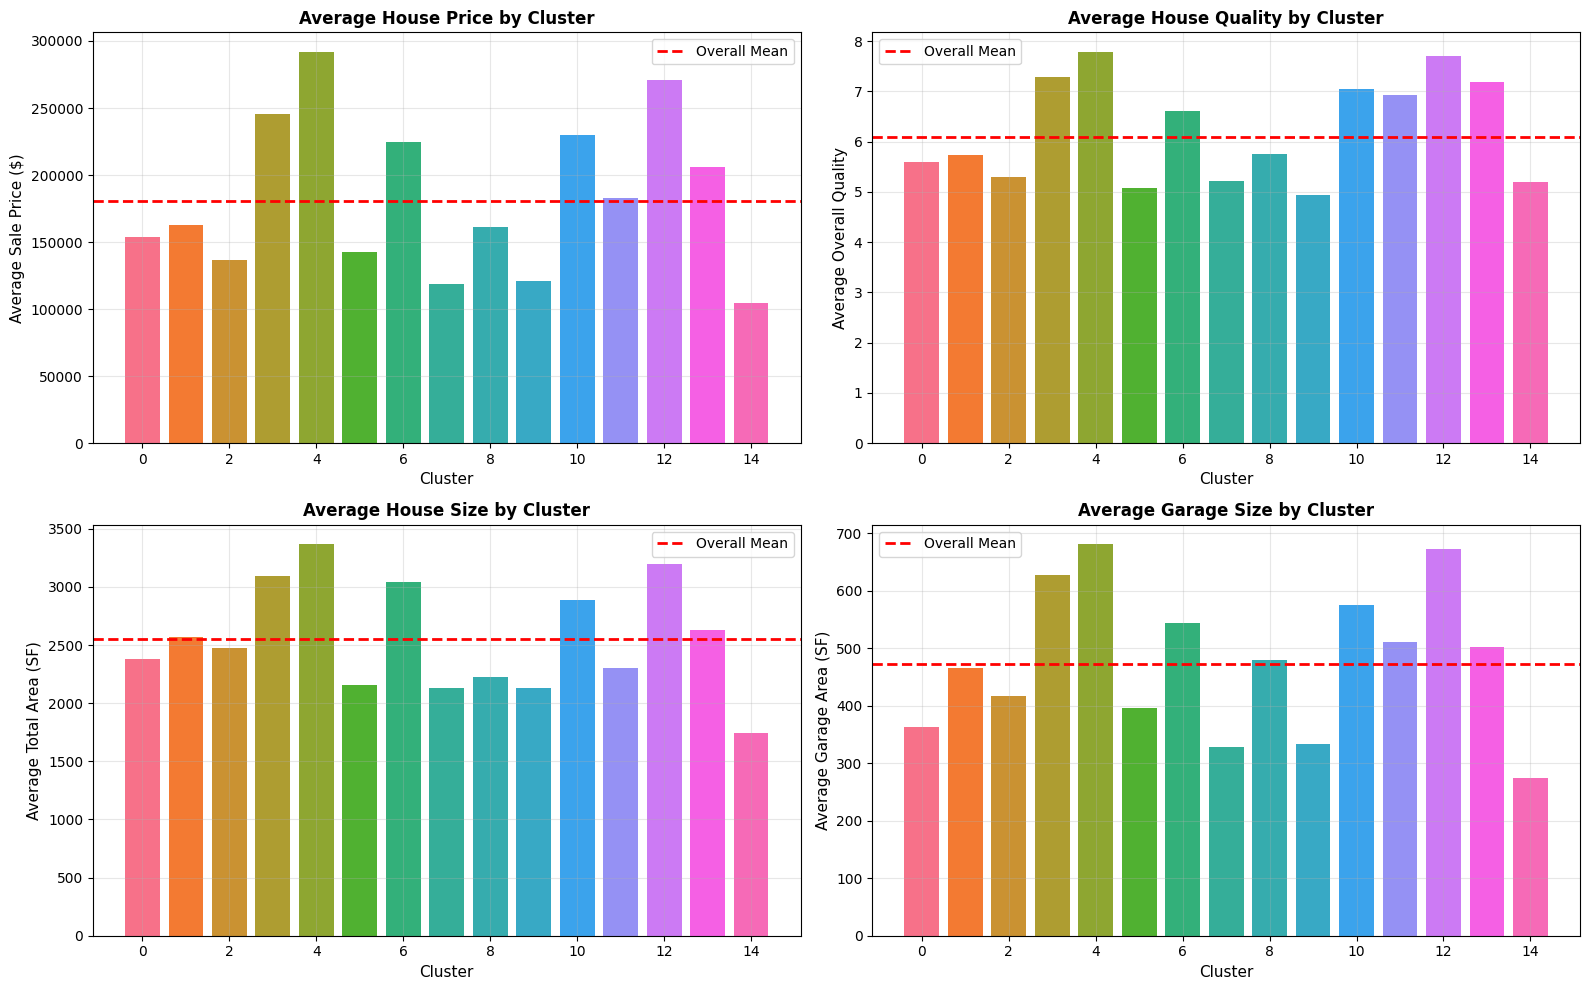

In [39]:
best_k = best_result['best_k']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = sns.color_palette("husl", best_k)

ax = axes[0, 0]
cluster_prices = analysis_df.groupby('Cluster')['SalePrice'].mean()
ax.bar(cluster_prices.index, cluster_prices.values, color=colors)
ax.axhline(y=analysis_df['SalePrice'].mean(), color='red', linestyle='--', 
           linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Average Sale Price ($)', fontsize=11)
ax.set_title('Average House Price by Cluster', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
cluster_quality = analysis_df.groupby('Cluster')['Overall Qual'].mean()
ax.bar(cluster_quality.index, cluster_quality.values, color=colors)
ax.axhline(y=analysis_df['Overall Qual'].mean(), color='red', linestyle='--', 
           linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Average Overall Quality', fontsize=11)
ax.set_title('Average House Quality by Cluster', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
cluster_size = analysis_df.groupby('Cluster')['TotalSF'].mean()
ax.bar(cluster_size.index, cluster_size.values, color=colors)
ax.axhline(y=analysis_df['TotalSF'].mean(), color='red', linestyle='--', 
           linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Average Total Area (SF)', fontsize=11)
ax.set_title('Average House Size by Cluster', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
cluster_garage = analysis_df.groupby('Cluster')['Garage Area'].mean()
ax.bar(cluster_garage.index, cluster_garage.values, color=colors)
ax.axhline(y=analysis_df['Garage Area'].mean(), color='red', linestyle='--', 
           linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Average Garage Area (SF)', fontsize=11)
ax.set_title('Average Garage Size by Cluster', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [40]:
for cluster_id in range(best_k):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} houses, {len(cluster_data)/len(analysis_df)*100:.1f}%)")
    print(f"Avg Price:        {cluster_data['SalePrice'].mean():>10,.0f} (±{cluster_data['SalePrice'].std():,.0f})")
    print(f"Avg Quality:      {cluster_data['Overall Qual'].mean():>10.1f}/10")
    print(f"Avg Size:         {cluster_data['TotalSF'].mean():>10.0f} SF")
    print(f"Avg Bathrooms:    {cluster_data['TotalBath'].mean():>10.1f}")
    print(f"Avg Garage Size:  {cluster_data['Garage Area'].mean():>10.0f} SF")
    print(f"Has Garage:       {(cluster_data['hasGarage'].sum() / len(cluster_data) * 100):>10.1f}%")
    print(f"Has Basement:     {(cluster_data['hasBasement'].sum() / len(cluster_data) * 100):>10.1f}%")
    print(f"Has Fireplace:    {(cluster_data['hasFireplace'].sum() / len(cluster_data) * 100):>10.1f}%")



CLUSTER 0 (208 houses, 7.1%)
Avg Price:           154,119 (±57,668)
Avg Quality:             5.6/10
Avg Size:               2382 SF
Avg Bathrooms:           1.8
Avg Garage Size:         363 SF
Has Garage:             92.3%
Has Basement:           98.6%
Has Fireplace:          59.1%
CLUSTER 1 (254 houses, 8.7%)
Avg Price:           162,812 (±40,226)
Avg Quality:             5.7/10
Avg Size:               2571 SF
Avg Bathrooms:           2.1
Avg Garage Size:         466 SF
Has Garage:             99.6%
Has Basement:           98.0%
Has Fireplace:          62.6%
CLUSTER 2 (148 houses, 5.1%)
Avg Price:           136,884 (±29,756)
Avg Quality:             5.3/10
Avg Size:               2476 SF
Avg Bathrooms:           2.5
Avg Garage Size:         417 SF
Has Garage:             80.4%
Has Basement:           81.8%
Has Fireplace:          22.3%
CLUSTER 3 (265 houses, 9.0%)
Avg Price:           245,679 (±89,167)
Avg Quality:             7.3/10
Avg Size:               3098 SF
Avg Bathrooms:     

In [ ]:

print("OPTIMAL K VALUES:")
for key, result in all_results.items():
    print(f"{key:30s}: k = {result['best_k']:2d}")

print("\nSILHOUETTE SCORES:")
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['best_silhouette'], reverse=True)
for rank, (key, result) in enumerate(sorted_results, 1):
    print(f"{rank}. {key:30s}: {result['best_silhouette']:.4f}")

print("\nPCA COMPONENTS:")
for key, result in all_results.items():
    print(f"{key:30s}: {result['pca'].n_components_:3d} components")




OPTIMAL K VALUES:
MinMax_nolog                  : k = 15
MinMax_log                    : k = 13
Standard_nolog                : k = 26
Standard_log                  : k = 30

SILHOUETTE SCORES:
1. MinMax_nolog                  : 0.1120
2. MinMax_log                    : 0.1062
3. Standard_nolog                : 0.0773
4. Standard_log                  : 0.0697

PCA COMPONENTS NEEDED:
MinMax_nolog                  :  76 components
MinMax_log                    :  75 components
Standard_nolog                : 136 components
Standard_log                  : 135 components
